
# Sistema de clasificación de tipos de cáncer cerebral mediante redes neuronales

## Setup para Google Colab (GPU T4) + MLflow

Este notebook se ejecuta en **Google Colab** usando GPU **T4** y registrar experimentos en **MLflow**.


In [46]:
!nvidia-smi

Thu Feb 19 03:23:01 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             30W /   70W |    1367MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Instalar dependencias 
!pip -q install -U mlflow kagglehub torchsummary seaborn ipywidgets

import os, torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    !nvidia-smi -L


from google.colab import drive
drive.mount('/content/drive')


os.environ["MLFLOW_TRACKING_URI"] = "http://<EC2_IP>:8050"
os.environ["MLFLOW_EXPERIMENT_NAME"] = "mri_tumor_classification_t4"

# Dataset (Drive)
os.environ["DATASET_DIR"] = "/content/drive/MyDrive/brain-mri/data/raw/brain-tumor-mri-scans"

print("MLFLOW_TRACKING_URI:", os.environ["MLFLOW_TRACKING_URI"])
print("MLFLOW_EXPERIMENT_NAME:", os.environ["MLFLOW_EXPERIMENT_NAME"])
print("DATASET_DIR:", os.environ["DATASET_DIR"])


CUDA available: True
GPU 0: Tesla T4 (UUID: GPU-0a7cdaf3-afc6-5bdf-6712-9ff655749c6b)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MLFLOW_TRACKING_URI: http://3.89.116.159:8050
MLFLOW_EXPERIMENT_NAME: mri_tumor_classification_t4
DATASET_DIR: /content/drive/MyDrive/brain-mri/data/raw/brain-tumor-mri-scans


In [48]:
import shutil
from pathlib import Path

DRIVE_DS = os.environ["DATASET_DIR"]
LOCAL_DS = "/content/brain-tumor-mri-scans"

if not Path(LOCAL_DS).exists():
    print("Copiando dataset desde Drive a /content ...")
    shutil.copytree(DRIVE_DS, LOCAL_DS)

os.environ["DATASET_DIR"] = LOCAL_DS
print("DATASET_DIR (local):", os.environ["DATASET_DIR"])

DATASET_DIR (local): /content/brain-tumor-mri-scans


In [49]:
torch.backends.cudnn.benchmark = True

try:
    torch.set_float32_matmul_precision("high")
except:
    pass

Desarrollar un método basado en redes neuronales convolucionales que permita
clasificar con exactitud imágenes extraídas de MRIs en una de las 4 categorías

- Glioma: Detecta masas anómalas con bordes irregulares y heterogeneidad en el tejido cerebral.
- Meningioma: Identifica tumores bien delimitados originados en las meninges.
- Pituitary: Clasifica adenomas hipofisarios en la región selar.
- Tejido sano: Diferencia el tejido cerebral normal sin anomalías presentes


In [ ]:
import mlflow

mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])
mlflow.set_experiment(os.environ["MLFLOW_EXPERIMENT_NAME"])

with mlflow.start_run(run_name="colab_ping"):
    mlflow.log_param("ping", 1)

print("Colab pudo loggear en MLflow")

2026/02/19 03:23:08 INFO mlflow.tracking.fluent: Experiment with name 'mri_tumor_classification_t4' does not exist. Creating a new experiment.


🏃 View run colab_ping at: http://3.89.116.159:8050/#/experiments/1/runs/a48b46a71d6e4239b90ce4ac4f409c9b
🧪 View experiment at: http://3.89.116.159:8050/#/experiments/1
✅ Colab pudo loggear en MLflow


In [51]:
pip install kagglehub

In [52]:
# Importar librerias
import random
import kagglehub
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import copy

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import pandas as pd


from collections import Counter

from torchvision import models
from torchsummary import summary

In [53]:
# (Opcional) Instalar MLflow si no está instalado
# !pip -q install mlflow

In [ ]:
import os
import mlflow
import mlflow.pytorch
from datetime import datetime
import json
from pathlib import Path

# =========================
# Configuración MLflow
# =========================
MLFLOW_TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI", "file:/content/mlruns")
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

EXPERIMENT_NAME = os.getenv("MLFLOW_EXPERIMENT_NAME", "mri_tumor_classification")
mlflow.set_experiment(EXPERIMENT_NAME)

print("MLFLOW_TRACKING_URI:", MLFLOW_TRACKING_URI)
print("Experiment:", EXPERIMENT_NAME)

ARTIFACT_DIR = Path("./artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)


MLFLOW_TRACKING_URI: http://3.89.116.159:8050
Experiment: mri_tumor_classification_t4


In [55]:
def _save_fig_and_log(fig, filename: str):
    path = ARTIFACT_DIR / filename
    fig.savefig(path, bbox_inches="tight", dpi=160)
    mlflow.log_artifact(str(path))
    return path

def log_training_curves(train_losses, val_losses, train_accs, val_accs, prefix: str):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(train_losses, label="train_loss")
    ax1.plot(val_losses, label="val_loss")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("loss")
    ax1.set_title(f"{prefix} - Loss")
    ax1.grid(True)
    ax1.legend()

    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(train_accs, label="train_acc")
    ax2.plot(val_accs, label="val_acc")
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("accuracy")
    ax2.set_title(f"{prefix} - Accuracy")
    ax2.grid(True)
    ax2.legend()

    _save_fig_and_log(fig, f"{prefix}_training_curves.png")
    plt.close(fig)

def evaluate_and_log(model, dataloader, device, prefix: str, class_names=None):
    import numpy as np
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    import matplotlib.pyplot as plt

    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Métricas globales
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    mlflow.log_metrics({
        f"{prefix}_accuracy": float(acc),
        f"{prefix}_precision_w": float(prec),
        f"{prefix}_recall_w": float(rec),
        f"{prefix}_f1_w": float(f1),
    })

    # Reporte de clasificación como artefacto
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    report_path = ARTIFACT_DIR / f"{prefix}_classification_report.txt"
    report_path.write_text(report, encoding="utf-8")
    mlflow.log_artifact(str(report_path))

    # Matriz de confusión como figura
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(1,1,1)
    im = ax.imshow(cm)
    ax.set_title(f"{prefix} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    fig.colorbar(im, ax=ax)

    # ticks si hay nombres
    if class_names is not None:
        ax.set_xticks(range(len(class_names)))
        ax.set_yticks(range(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45, ha="right")
        ax.set_yticklabels(class_names)

    # anotar valores
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")

    _save_fig_and_log(fig, f"{prefix}_confusion_matrix.png")
    plt.close(fig)

    # Guardar métricas en JSON
    metrics_path = ARTIFACT_DIR / f"{prefix}_eval_metrics.json"
    metrics_path.write_text(json.dumps({
        "accuracy": float(acc),
        "precision_weighted": float(prec),
        "recall_weighted": float(rec),
        "f1_weighted": float(f1),
    }, indent=2), encoding="utf-8")
    mlflow.log_artifact(str(metrics_path))

    return y_true, y_pred


In [56]:
# Descargar el enlace del Dataset
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-scans' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-scans


In [57]:
# Verificar que se esté trabajando con GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


### 1. Preprocesamiento de imagenes

### 1.1 Parámetros para el preprocesado

In [ ]:
import os
import kagglehub
import torch

# =========================
# Configuración de datos / hiperparámetros
# =========================
DATASET_SLUG = "rm1000/brain-tumor-mri-scans"
dataset_path = os.getenv("DATASET_DIR")

if not dataset_path:
    print(f"DATASET_DIR no definido. Descargando con kagglehub: {DATASET_SLUG}")
    dataset_path = kagglehub.dataset_download(DATASET_SLUG)

print("Dataset path:", dataset_path)

# Tamaño de las imágenes 
img_size = int(os.getenv("IMG_SIZE", "180"))

# Tamaño de batch 
batch_size = int(os.getenv("BATCH_SIZE", "32"))

# Porcentaje de datos para validación 
val_split = float(os.getenv("VAL_SPLIT", "0.2"))

# Semilla 
seed = int(os.getenv("SEED", "42"))
torch.manual_seed(seed)

print({"img_size": img_size, "batch_size": batch_size, "val_split": val_split, "seed": seed})


Dataset path: /content/brain-tumor-mri-scans
{'img_size': 180, 'batch_size': 32, 'val_split': 0.2, 'seed': 42}


### 1.2 Pipeline de preprocesamiento

A continuacion se screa el pipeline de preprocesamiento de images, el cual realiza los siguientes pasos:
* redimensiona la imagen a 180x180
* se Convierte la imagen para que tenga un solo canal en escala de grices.
* se aplica normalizacion a los datos para que queden en el rando de [-1, 1]
------
Para el conjunto de datos de entrenamiento, se decide aplicar, además de los pasos previos, técnicas de aumento de datos (data augmentation) para enriquecer la variedad de ejemplos y mejorar la generalización del modelo.
* se  refleja la imagen de izquierda a derecha.
* se rota la imagen de manera aleatoria entre -15 y 15 grados.
* se ajusta aleatoriamente el brillo y el contraste de la imagen dentro de un rango de 0.2

In [59]:
# Pipeline de preparación de imágenes (Proprocesamiento)

# Transformaciones para el conjunto de entrenamiento con data augmentation
train_transform = transforms.Compose([
    # Redimensiona la imagen para que todas tengan un tamaño fijo
    transforms.Resize((img_size, img_size)),
    # Convierte las imágenes a escalas de grises para tener 1 solo canal
    transforms.Grayscale(num_output_channels=1),

    ###### inicio data augmentation en train #######
    # Reflejar de forma horizontal la imagen
    transforms.RandomHorizontalFlip(),
    # Rotaciones aleatorias de la imágen entre -15 y 15 grados
    transforms.RandomRotation(degrees=15),
    # Desplaza horizontal y verticalmente las imágenes
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    # Variación de brillo y contraste, simula variaciones en el brillo y contraste
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    ###### fin data augmentation en train #######

    # Convierte imágenes en tensores de [0,255] a [0,1]
    transforms.ToTensor(),
    # Centrar alrededor de 0 con un rango aproximado de [-1,1]
    transforms.Normalize([0.5], [0.5])
])

# Transformaciones para el conjunto de validación
val_transform = transforms.Compose([
    # Redimensiona la imagen para que todas tengan un tamaño fijo
    transforms.Resize((img_size, img_size)),
    # Convierte las imágenes a escalas de grises para tener 1 solo canal y no 3 duplicados
    transforms.Grayscale(num_output_channels=1),
    # Convierte imágenes en tensores de [0,255] a [0,1]
    transforms.ToTensor(),
    # Centrar alrededor de 0 con un rango aproximado de [-1,1]
    transforms.Normalize([0.5], [0.5])
])

### 2. Division del dataset

El dataset se divide en datos de train y val. Adicional, se aplica el pipeline de preprocesado.

In [60]:
# --- Recomendación Colab ---
# 2–4 workers suele ser el punto dulce. Empieza con 2.
num_workers = int(os.getenv("NUM_WORKERS", 2))

# pin_memory acelera la transferencia CPU->GPU
pin_memory = torch.cuda.is_available()

# prefetch_factor solo aplica si num_workers>0
prefetch_factor = 2 if num_workers > 0 else None

# =========================
# Dataset + split
# =========================
dataset = datasets.ImageFolder(root=dataset_path)
labels = [item[1] for item in dataset.samples]

Stratified = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=seed)
train_index, val_index = next(Stratified.split(np.zeros(len(labels)), labels))

train_dataset = ImageFolder(root=dataset_path, transform=train_transform)
val_dataset   = ImageFolder(root=dataset_path, transform=val_transform)

train_db = torch.utils.data.Subset(train_dataset, train_index)
val_db   = torch.utils.data.Subset(val_dataset, val_index)

# =========================
# DataLoaders optimizados
# =========================
train_data_load = DataLoader(
    train_db,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=(num_workers > 0),
    prefetch_factor=prefetch_factor if prefetch_factor is not None else 2,
    drop_last=True,  # mejora rendimiento y estabilidad de batch
)

val_data_load = DataLoader(
    val_db,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=(num_workers > 0),
    prefetch_factor=prefetch_factor if prefetch_factor is not None else 2,
)

Se obtiene la ditribuccion de las clases para el dataset completo y tambien para las divisiones previas que se realizaron.


Dataset completo
Etiqueta: glioma, Cantidad de imágenes: 1621
Etiqueta: healthy, Cantidad de imágenes: 2000
Etiqueta: meningioma, Cantidad de imágenes: 1645
Etiqueta: pituitary, Cantidad de imágenes: 1757


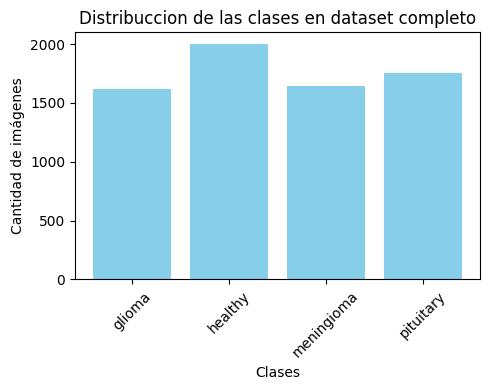


Dataset de Entrenamiento
Etiqueta: healthy, Cantidad de imágenes: 1600
Etiqueta: pituitary, Cantidad de imágenes: 1405
Etiqueta: meningioma, Cantidad de imágenes: 1316
Etiqueta: glioma, Cantidad de imágenes: 1297

Dataset de Validación
Etiqueta: healthy, Cantidad de imágenes: 400
Etiqueta: glioma, Cantidad de imágenes: 324
Etiqueta: pituitary, Cantidad de imágenes: 352
Etiqueta: meningioma, Cantidad de imágenes: 329


In [61]:
# Imprimir la cantidad de imágenes por cada categoría (Clase)
class_counts = Counter(labels)
print("\nDataset completo")
for class_idx, count in class_counts.items():
    # Obtener el nombre de la clase a partir del índice
    class_name = dataset.classes[class_idx]
    print(f"Etiqueta: {class_name}, Cantidad de imágenes: {count}")

plt.figure(figsize=(5, 4))
plt.bar([dataset.classes[class_idx] for class_idx in class_counts.keys()], list(class_counts.values()), color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Cantidad de imágenes')
plt.title('Distribuccion de las clases en dataset completo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Para el dataset de entrenamiento
train_labels = [dataset.samples[i][1] for i in train_db.indices]
train_class_counts = Counter(train_labels)

# Para el dataset de validación
val_labels = [dataset.samples[i][1] for i in val_db.indices]
val_class_counts = Counter(val_labels)

# Imprimir resultados del set de entrenamiento
print("\nDataset de Entrenamiento")
for class_idx, count in train_class_counts.items():
    class_name = dataset.classes[class_idx]
    print(f"Etiqueta: {class_name}, Cantidad de imágenes: {count}")

# Imprimir resultados del set de validación
print("\nDataset de Validación")
for class_idx, count in val_class_counts.items():
    class_name = dataset.classes[class_idx]
    print(f"Etiqueta: {class_name}, Cantidad de imágenes: {count}")

### 4. Funcion de entrenamiento ( train)

* Coloca el modelo en modo entrenamiento (model.train()).
* Recorre los minibatches del conjunto de entrenamiento.

Para cada batch:

* Reinicia los gradientes del optimizador.
* Realiza una pasada hacia adelante.
* Calcula la pérdida.
* Realiza retropropagación.
* Actualiza los pesos del modelo
* Acumula la pérdida total y el número de predicciones correctas.

In [62]:
# Función de entrenamiento

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy

### 5. Funcion de evaluacion (evaluate)

* Pone el modelo en modo evaluación (model.eval())
* Desactiva el cálculo de gradientes para acelerar el proceso

Recorre los batches del conjunto de validación y:

* Obtiene las predicciones y calcula la pérdida.
* Acumula la pérdida total y la cantidad de predicciones correctas.
* Devuelve la pérdida promedio y la precisión en validación.

In [63]:
# Función de evaluación

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy

### 7. Etapa de modelado

Para abordar el caso planteado, se decide probar 3 soluciones, dos de ella con arquitecturas propuestas en investigaciones relacionadas y la última a partir de transfer learning con EfficientNetB0 de la familia de EfficientNet de Google:

### Arquitectura # 1 Red Neuronal Convolicional (CNN)

Esta CNN cuenta con tres bloques:

Bloque 1: Busca extraer características simples (Bordes, contornos y patrones simples):


* Capa 1: 4 filtros, kernel 3x3 y padding=1.
* Capa 2: 8 filtros, kernel 3x3 y padding=1.
* Batch Normalization después de cada convolución.
* Maxpool: 2x2, reduce resolución a la mitad


Bloque 2: Busca extraer características como texturas y formas más complejas:

* Capa 1: 16 filtros, kernel 5x5 y padding=2.
* Capa 2: 32 filtros, kernel 5x5 y padding=2.
* Capa 2: 64 filtros, kernel 5x5 y padding=2.
* Batch Normalization después de cada convolución.
* Maxpool: 2x2, reduce resolución a la mitad

Bloque 3: Busca extraer características más profundas:

* Capa 1: 128 filtros, kernel 5x5 y padding=2.
* Capa 2: 256 filtros, kernel 5x5 y padding=2.
* Batch Normalization después de cada convolución.
* AdaptiveAvgPool: Ayuda a garantizar una salida fija, necesaria para la capa densa.

Bloque 4: Bloque de clasificación (4 clases):

* Flatten del tensor (1024)
* Capa densa: Predicción de clases.

In [64]:
class TumorMRICNN(nn.Module):
    def __init__(self, num_classes=4):
        super(TumorMRICNN, self).__init__()

        # Estás capas iniciales buscan identificar características mas simples como bordes, contornos o lineas
        # Capa convolicional 1 con entrada (1 canal) , con 4 filtros, kernel 3x3 con stride de 1 y padding para no perder los bordes
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(4)

        # Capa convolicional 2 con 8 filtros, kernel 3x3 con stride de 1 y padding para no perder los bordes
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(8)

        # Max Pooling de 2x2 con un stride de 2 que reduce la imagen a la mitad conservando la representación
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Estás capas con mayor cantidad de filtros pretenden identificar carácterísticas mas complejas como los tumores
        # Capa convolicional 3 con 16 filtros, kernel 5x5 con stride de 1 y padding de 2 dado que el kernel es 5x5 para no perder los bordes
        self.conv3 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(16)

        # Capa convolicional 4 con 32 filtros, kernel 5x5 con stride de 1 y padding de 2 dado que el kernel es 5x5 para no perder los bordes
        self.conv4 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(32)

        # Capa convolicional 5 con 64 filtros, kernel 5x5 con stride de 1 y padding de 2 dado que el kernel es 5x5 para no perder los bordes
        self.conv5 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn5 = nn.BatchNorm2d(64)

        # Max Pooling con un stride de 2 que reduce la imagen a la mitad conservando la representación
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Capa convolicional 6 con 128 filtros, kernel 7x7 con stride de 1 y padding de 3 dado que el kernel es 7x7 ((7-1/2)) para no perder los bordes
        self.conv6 = nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=3)
        self.bn6 = nn.BatchNorm2d(128)

        # Capa convolicional 7 con 256 filtros, kernel 3x3 con stride de 1 y padding de 1 dado que el kernel es 3x3 para no perder los bordes
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)

        # Max Pooling final, este es adaptativo y fuerza la salida a 2x2 dado que la la capa completamente conectada requiere que este tamaño sea fijo
        self.pool3 = nn.AdaptiveAvgPool2d((2, 2))

        # Fully connected layer
        self.fc = nn.Linear(256 * 2 * 2, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool2(x)

        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool3(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

### Definicion de optimizador y funcion de perdida
se implementa el optimizador Adam con una tasa de aprendizaje del 0.001 y funcion de perdida CrossEntropyLoss

In [65]:
# Instanciar modelo
model_1 = TumorMRICNN(num_classes=4).to(device)

# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Optimizador
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

print(model_1)

TumorMRICNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [66]:
summary(model_1, input_size=(1, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 180, 180]              40
       BatchNorm2d-2          [-1, 4, 180, 180]               8
            Conv2d-3          [-1, 8, 180, 180]             296
       BatchNorm2d-4          [-1, 8, 180, 180]              16
         MaxPool2d-5            [-1, 8, 90, 90]               0
            Conv2d-6           [-1, 16, 90, 90]           3,216
       BatchNorm2d-7           [-1, 16, 90, 90]              32
            Conv2d-8           [-1, 32, 90, 90]          12,832
       BatchNorm2d-9           [-1, 32, 90, 90]              64
           Conv2d-10           [-1, 64, 90, 90]          51,264
      BatchNorm2d-11           [-1, 64, 90, 90]             128
        MaxPool2d-12           [-1, 64, 45, 45]               0
           Conv2d-13          [-1, 128, 45, 45]         401,536
      BatchNorm2d-14          [-1, 128,

### Entrenamiento y evaluación del modelo

Se aplican las funciones de entrenamiento y evaluación en un bucle durante 150 épocas con una parada temprana de 20, observando el progreso del modelo en cada una de ellas.

In [67]:
# =========================
# Entrenamiento con MLflow
# =========================
num_epochs = 20
patience = 5

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = np.inf
best_model_wts = copy.deepcopy(model_1.state_dict())
epochs_without_improvement = 0

# (Opcional) nombres de clases
class_names = None
try:
    class_names = val_dataset.classes
except Exception:
    pass

# Conteo de parámetros entrenables
trainable_params = sum(p.numel() for p in model_1.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_1.parameters())

with mlflow.start_run(run_name="arq_1_TumorMRICNN"):
    # Tags útiles para comparar modelos en MLflow
    mlflow.set_tags({
        "project": "MRI Tumor Classification",
        "model_arch": "TumorMRICNN",
        "framework": "pytorch",
    })

    # Parámetros (ajusta/añade según tu caso)
    mlflow.log_params({
        "num_epochs": num_epochs,
        "patience": patience,
        "lr": optimizer.param_groups[0].get("lr", None),
        "batch_size": getattr(train_data_load, "batch_size", None),
        "img_size": locals().get("img_size", None),
        "val_split": locals().get("val_split", None),
        "seed": locals().get("seed", None),
        "trainable_params": trainable_params,
        "total_params": total_params,
    })

    # Guardar arquitectura como artefacto
    arch_path = ARTIFACT_DIR / "arq_1_TumorMRICNN_model_arch.txt"
    arch_path.write_text(str(model_1), encoding="utf-8")
    mlflow.log_artifact(str(arch_path))

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model_1, train_data_load, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model_1, val_data_load, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Log de métricas por época (clave: step=epoch)
        mlflow.log_metrics({
            "train_loss": float(train_loss),
            "val_loss": float(val_loss),
            "train_acc": float(train_acc),
            "val_acc": float(val_acc),
        }, step=epoch)

        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'| Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} '
              f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # Guardar mejor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model_1.state_dict())
            epochs_without_improvement = 0
            torch.save(model_1.state_dict(), 'best_model_arq_1.pth')
            mlflow.log_metric("best_val_loss", float(best_val_loss), step=epoch)
            print(f"Mejor modelo guardado en la época {epoch+1} con pérdida de validación {best_val_loss:.4f}")
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Parada temprana en la época {epoch+1}")
            break

    # Cargar el mejor modelo al final
    model_1.load_state_dict(best_model_wts)

    # Curvas como artefacto
    prefix = "arq_1_TumorMRICNN"
    log_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, prefix)

    # Log del checkpoint final (mejor)
    if os.path.exists('best_model_arq_1.pth'):
        mlflow.log_artifact('best_model_arq_1.pth')

    # Evaluación final + artefactos (reporte + matriz confusión)
    _ = evaluate_and_log(model_1, val_data_load, device, prefix=prefix, class_names=class_names)

print("Run registrado en MLflow")


Epoch [1/20] | Train Loss: 0.8130 | Train Acc: 0.6630 | Val Loss: 0.9010 | Val Acc: 0.6512
Mejor modelo guardado en la época 1 con pérdida de validación 0.9010
Epoch [2/20] | Train Loss: 0.6450 | Train Acc: 0.7412 | Val Loss: 0.5630 | Val Acc: 0.7929
Mejor modelo guardado en la época 2 con pérdida de validación 0.5630
Epoch [3/20] | Train Loss: 0.5757 | Train Acc: 0.7668 | Val Loss: 0.5776 | Val Acc: 0.7751
Epoch [4/20] | Train Loss: 0.5215 | Train Acc: 0.7913 | Val Loss: 0.6423 | Val Acc: 0.7203
Epoch [5/20] | Train Loss: 0.4631 | Train Acc: 0.8213 | Val Loss: 0.6001 | Val Acc: 0.7872
Epoch [6/20] | Train Loss: 0.4138 | Train Acc: 0.8361 | Val Loss: 0.7480 | Val Acc: 0.7103
Epoch [7/20] | Train Loss: 0.3952 | Train Acc: 0.8488 | Val Loss: 0.4735 | Val Acc: 0.8214
Mejor modelo guardado en la época 7 con pérdida de validación 0.4735
Epoch [8/20] | Train Loss: 0.3526 | Train Acc: 0.8630 | Val Loss: 0.4951 | Val Acc: 0.8100
Epoch [9/20] | Train Loss: 0.3094 | Train Acc: 0.8827 | Val Loss:

In [68]:
# Cargar mejor modelo para sacar metricas
model_1 = TumorMRICNN(num_classes=4).to(device)
model_1.load_state_dict(torch.load('best_model_arq_1.pth'))
model_1.eval()

TumorMRICNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

### Reporte de clasificación arquitectura 1

In [69]:
# Obtener todas las predicciones y etiquetas verdaderas
y_true_1 = []
y_pred_1 = []

model_1.eval()
with torch.no_grad():
    for images, labels in val_data_load:
        images, labels = images.to(device), labels.to(device)
        outputs = model_1(images)
        _, preds = torch.max(outputs, 1)
        y_true_1.extend(labels.cpu().numpy())
        y_pred_1.extend(preds.cpu().numpy())

# Reporte detallado
print(classification_report(y_true_1, y_pred_1, target_names=val_dataset.classes))

              precision    recall  f1-score   support

      glioma       0.88      0.91      0.90       324
     healthy       0.95      0.96      0.95       400
  meningioma       0.83      0.80      0.81       329
   pituitary       0.95      0.93      0.94       352

    accuracy                           0.91      1405
   macro avg       0.90      0.90      0.90      1405
weighted avg       0.90      0.91      0.91      1405



### Arquitectura # 2 Red Neuronal Convolicional (CNN)

Cada bloque contiene:

* Dos capas Conv2D con kernel 3x3 y padding=1.
* Batch Normalization después de cada convolución.
* Activación ReLU.
* MaxPooling2D (2x2) para reducir el tamaño espacial.
* Dropout para evitar sobreajuste (25%).

La cantidad de filtros en los bloques es:

* 1° bloque: 64 filtros
* 2° bloque: 32 filtros
* 3° bloque: 16 filtros
* 4° bloque: 8 filtros

Capas Finales

* Flatten del tensor
* Capa densa de 968 unidades a 1024 unidades, con Dropout (50%).
* Capa de salida de 1024 a 4 unidades (una por clase).

In [70]:
class MultiClassifier1(nn.Module):
    def __init__(self):
        super(MultiClassifier1, self).__init__()

        #-------------------- Primer bloque convolucional --------------------------
        # Capa convolicional 1 con entrada (1 canal) , con 64 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64) # Normalización por lotes

        # Capa convolicional 2 con 64 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # Normalización por lotes

        # Max Pooling para Reducción de tamaño espacial
        self.maxpool1 = nn.MaxPool2d(2, 2)
        # Dropout para evitar sobreajuste
        self.dropout1 = nn.Dropout(0.25)

        #-------------------- Segundo bloque convolucional --------------------------
        # Capa convolicional 3 con 32 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        # Capa convolicional 4 con 32 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        # Max Pooling para Reducción de tamaño espacial
        self.maxpool2 = nn.MaxPool2d(2, 2)
        # Dropout para evitar sobreajuste
        self.dropout2 = nn.Dropout(0.25)

        #-------------------- Tercer bloque convolucional --------------------------
        # Capa convolicional 5 con 16 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv5 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(16)

        # Capa convolicional 6 con 16 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(16)

        # Max Pooling para Reducción de tamaño espacial
        self.maxpool3 = nn.MaxPool2d(2, 2)
        # Dropout para evitar sobreajuste
        self.dropout3 = nn.Dropout(0.25)

        #-------------------- Cuarto bloque convolucional --------------------------
        # Capa convolicional 7 con 8 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv7 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(8)

        # Capa convolicional 8 con 8 filtros, kernel 3x3 y padding para no perder los bordes
        self.conv8 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(8)

        # Max Pooling para Reducción de tamaño espacial
        self.maxpool4 = nn.MaxPool2d(2, 2)
        # Dropout para evitar sobreajuste
        self.dropout4 = nn.Dropout(0.25)

        # Capa de flatten para convertir el tensor en vector
        self.flatten = nn.Flatten()

        # Capa densa 1 completamente conectada
        self.fc1 = nn.Linear(8 * 11 * 11, 1024)  # 8x11x11 debido a la reducción de tamaño en las capas previas
        self.dropout5 = nn.Dropout(0.5)

        # Capa de salida
        self.fc2 = nn.Linear(1024, 4)  # 4 clases para la clasificación

    def forward(self, x):
        # se pasan las imágenes a través de las capas convolucionales
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.maxpool3(x)
        x = self.dropout3(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.maxpool4(x)
        x = self.dropout4(x)

        # Aplanamos la salida para las capas totalmente conectadas
        x = self.flatten(x)

        # Capa densa 1
        x = F.relu(self.fc1(x))
        x = self.dropout5(x)

        # Capa de salida (para clasificación)
        x = self.fc2(x)

        return x

### Definicion de optimizador y funcion de perdida
se implementa el optimizador Adam con una tasa de aprendizaje del 0.001 y funcion de perdida CrossEntropyLoss

In [71]:
# instancia del modelo
model_2 = MultiClassifier1().to(device)

# funcion de perdida
criterion = nn.CrossEntropyLoss()

# optimizador
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

print(model_2)

MultiClassifier1(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), strid

In [72]:
summary(model_2, input_size=(1, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 180, 180]             640
       BatchNorm2d-2         [-1, 64, 180, 180]             128
            Conv2d-3         [-1, 64, 180, 180]          36,928
       BatchNorm2d-4         [-1, 64, 180, 180]             128
         MaxPool2d-5           [-1, 64, 90, 90]               0
           Dropout-6           [-1, 64, 90, 90]               0
            Conv2d-7           [-1, 32, 90, 90]          18,464
       BatchNorm2d-8           [-1, 32, 90, 90]              64
            Conv2d-9           [-1, 32, 90, 90]           9,248
      BatchNorm2d-10           [-1, 32, 90, 90]              64
        MaxPool2d-11           [-1, 32, 45, 45]               0
          Dropout-12           [-1, 32, 45, 45]               0
           Conv2d-13           [-1, 16, 45, 45]           4,624
      BatchNorm2d-14           [-1, 16,

### Entrenamiento y evaluación del modelo

Se aplican las funciones de entrenamiento y evaluación en un bucle durante 150 épocas con una parada temprana de 20, observando el progreso del modelo en cada una de ellas.

In [73]:
# =========================
# Entrenamiento con MLflow
# =========================
num_epochs = 20
patience = 5

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = np.inf
best_model_wts = copy.deepcopy(model_2.state_dict())
epochs_without_improvement = 0

# (Opcional) nombres de clases
class_names = None
try:
    class_names = val_dataset.classes
except Exception:
    pass

# Conteo de parámetros entrenables
trainable_params = sum(p.numel() for p in model_2.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_2.parameters())

with mlflow.start_run(run_name="arq_2_MultiClassifier1"):
    # Tags útiles para comparar modelos en MLflow
    mlflow.set_tags({
        "project": "MRI Tumor Classification",
        "model_arch": "MultiClassifier1",
        "framework": "pytorch",
    })

    # Parámetros (ajusta/añade según tu caso)
    mlflow.log_params({
        "num_epochs": num_epochs,
        "patience": patience,
        "lr": optimizer.param_groups[0].get("lr", None),
        "batch_size": getattr(train_data_load, "batch_size", None),
        "img_size": locals().get("img_size", None),
        "val_split": locals().get("val_split", None),
        "seed": locals().get("seed", None),
        "trainable_params": trainable_params,
        "total_params": total_params,
    })

    # Guardar arquitectura como artefacto
    arch_path = ARTIFACT_DIR / "arq_2_MultiClassifier1_model_arch.txt"
    arch_path.write_text(str(model_2), encoding="utf-8")
    mlflow.log_artifact(str(arch_path))

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model_2, train_data_load, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model_2, val_data_load, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Log de métricas por época (clave: step=epoch)
        mlflow.log_metrics({
            "train_loss": float(train_loss),
            "val_loss": float(val_loss),
            "train_acc": float(train_acc),
            "val_acc": float(val_acc),
        }, step=epoch)

        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'| Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} '
              f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # Guardar mejor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model_2.state_dict())
            epochs_without_improvement = 0
            torch.save(model_2.state_dict(), 'best_model_arq_2.pth')
            mlflow.log_metric("best_val_loss", float(best_val_loss), step=epoch)
            print(f"Mejor modelo guardado en la época {epoch+1} con pérdida de validación {best_val_loss:.4f}")
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Parada temprana en la época {epoch+1}")
            break

    # Cargar el mejor modelo al final
    model_2.load_state_dict(best_model_wts)

    # Curvas como artefacto
    prefix = "arq_2_MultiClassifier1"
    log_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, prefix)

    # Log del checkpoint final (mejor)
    if os.path.exists('best_model_arq_2.pth'):
        mlflow.log_artifact('best_model_arq_2.pth')

    # Evaluación final + artefactos (reporte + matriz confusión)
    _ = evaluate_and_log(model_2, val_data_load, device, prefix=prefix, class_names=class_names)

print("Run registrado en MLflow")


Epoch [1/20] | Train Loss: 0.8881 | Train Acc: 0.6284 | Val Loss: 0.5709 | Val Acc: 0.7765
Mejor modelo guardado en la época 1 con pérdida de validación 0.5709
Epoch [2/20] | Train Loss: 0.6407 | Train Acc: 0.7377 | Val Loss: 0.4651 | Val Acc: 0.8235
Mejor modelo guardado en la época 2 con pérdida de validación 0.4651
Epoch [3/20] | Train Loss: 0.5706 | Train Acc: 0.7684 | Val Loss: 0.4862 | Val Acc: 0.7751
Epoch [4/20] | Train Loss: 0.4907 | Train Acc: 0.7982 | Val Loss: 0.4856 | Val Acc: 0.8142
Epoch [5/20] | Train Loss: 0.4628 | Train Acc: 0.8170 | Val Loss: 0.3676 | Val Acc: 0.8676
Mejor modelo guardado en la época 5 con pérdida de validación 0.3676
Epoch [6/20] | Train Loss: 0.4467 | Train Acc: 0.8227 | Val Loss: 0.3520 | Val Acc: 0.8683
Mejor modelo guardado en la época 6 con pérdida de validación 0.3520
Epoch [7/20] | Train Loss: 0.4055 | Train Acc: 0.8361 | Val Loss: 0.3446 | Val Acc: 0.8790
Mejor modelo guardado en la época 7 con pérdida de validación 0.3446
Epoch [8/20] | Tra

In [74]:
# Cargar mejor modelo para sacar metricas
model_2 = MultiClassifier1().to(device)
model_2.load_state_dict(torch.load('best_model_arq_2.pth'))
model_2.eval()

MultiClassifier1(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), strid

In [75]:
summary(model_2, input_size=(1, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 180, 180]             640
       BatchNorm2d-2         [-1, 64, 180, 180]             128
            Conv2d-3         [-1, 64, 180, 180]          36,928
       BatchNorm2d-4         [-1, 64, 180, 180]             128
         MaxPool2d-5           [-1, 64, 90, 90]               0
           Dropout-6           [-1, 64, 90, 90]               0
            Conv2d-7           [-1, 32, 90, 90]          18,464
       BatchNorm2d-8           [-1, 32, 90, 90]              64
            Conv2d-9           [-1, 32, 90, 90]           9,248
      BatchNorm2d-10           [-1, 32, 90, 90]              64
        MaxPool2d-11           [-1, 32, 45, 45]               0
          Dropout-12           [-1, 32, 45, 45]               0
           Conv2d-13           [-1, 16, 45, 45]           4,624
      BatchNorm2d-14           [-1, 16,

### Arquitectura # 3 Red Neuronal Convolicional (CNN)  - EfficientNetB0

Esta CNN cuenta con tres "Grandes" bloques:

Bloque 1: Busca extraer características simples (Bordes, contornos y patrones simples):


* Capa 1 Conv2d: 32 filtros, kernel 3x3 y padding=1.
* Batch Normalization después de cada convolución.
* Maxpool: 2x2, reduce resolución a la mitad


Bloque 2: Este bloque en relidad cuenta con 16 bloques de MBConv (Mobile Inverted Bottleneck Convolution), busca extraer características como texturas y formas más complejas:

| Etapa | Tipo de bloque | # Bloques | Filtros (in → out) | Kernel |
|-------|----------------|-----------|---------------------|--------|
| MBConv1 | 1 bloque     | 1         | 32 → 16             | 3×3    |
| MBConv6 | 2 bloques    | 2         | 16 → 24             | 3×3    |
| MBConv6 | 2 bloques    | 2         | 24 → 40             | 5×5    |
| MBConv6 | 3 bloques    | 3         | 40 → 80             | 3×3    |
| MBConv6 | 3 bloques    | 3         | 80 → 112            | 5×5    |
| MBConv6 | 4 bloques    | 4         | 112 → 192           | 5×5    |
| MBConv6 | 1 bloque     | 1         | 192 → 320           | 3×3    |


Bloque 3: Bloque de clasificación (4 clases):

* Capa 1 Conv2d: 1280 filtros, kernel 1x1 y padding=1.
* AdaptiveAvgPool2d(1×1)
* Dropout(p=0.2)
* Capa densa: Predicción de clases (linear).

### Preprocesado:

Dada la literatura, esta red es recomendable con un tamaño de imágen de 224x224, con tres canales y una normalización propia.

In [76]:
# Tamaño de las imágenes
img_size = 224

# Tamaño de batch
batch_size = 16

# Porcentaje de datos para validación
val_split = 0.2

# Semilla
seed = 42
torch.manual_seed(seed)

###  Pipeline de preprocesamiento

A continuacion se se crea el pipeline de preprocesamiento de images, el cual realiza los siguientes pasos:
* redimensiona la imagen a 224x224
* se aplica normalizacion propia para esta red
------
Para el conjunto de datos de entrenamiento, se decide aplicar, además de los pasos previos, técnicas de aumento de datos (data augmentation) para enriquecer la variedad de ejemplos y mejorar la generalización del modelo.
* se  refleja la imagen de izquierda a derecha.
* se rota la imagen de manera aleatoria entre -15 y 15 grados.
* se ajusta aleatoriamente el brillo y el contraste de la imagen dentro de un rango de 0.2

In [77]:
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    # Normalización estándar ImageNet
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

### Division del dataset

El dataset se divide en datos de train y val. Adicional, se aplica el pipeline de preprocesado.

In [78]:
import os
NUM_WORKERS = int(os.getenv('NUM_WORKERS','2'))
# Cargar el dataset con ImageFolder dado que la estructura provienen de directorios

dataset = datasets.ImageFolder(root=dataset_path)

# Obtener las etiquetas de las imágenes
labels = [item[1] for item in dataset.samples]

# Dividimos el dataset de manera estratificada
Stratified = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=seed)

for train_index, val_index in Stratified.split(np.zeros(len(labels)), labels):
    pass  # Solo necesitamos una división

# Con transform aplicar el pipeline de preprocesado espeficado en la celda anterior para cada dataset
train_dataset = ImageFolder(root=dataset_path, transform=train_transform)
val_dataset = ImageFolder(root=dataset_path, transform=val_transform)

# Seleccionamos los indices adecuado de cada dataset transformado
train_db = torch.utils.data.Subset(train_dataset, train_index)
val_db = torch.utils.data.Subset(val_dataset, val_index)

# Cargamos los datos por baches
train_data_load = DataLoader(train_db, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_data_load = DataLoader(val_db, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

###  Intanciar el modelo y configurar el proceso de transfer learning

In [79]:
model_3 = models.efficientnet_b0(pretrained=True)

# Descongelar capas para realizar el proceso de Fine-tuning con los datos propios
for param in model_3.features.parameters():
    param.requires_grad = True

# Reemplazar la última capa para clasificación en 4 clases
num_features = model_3.classifier[1].in_features
model_3.classifier[1] = nn.Linear(num_features, 4)  # 4 clases: glioma, meningioma, pituitary, healthy

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 176MB/s]


### Definicion de optimizador y funcion de perdida
se implementa el optimizador Adam con una tasa de aprendizaje del 0.001 y funcion de perdida CrossEntropyLoss

In [80]:
model_3 = model_3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [81]:
summary(model_3, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

### Entrenamiento y evaluación del modelo

Se aplican las funciones de entrenamiento y evaluación en un bucle durante 150 épocas con una parada temprana de 20, observando el progreso del modelo en cada una de ellas.

In [82]:
# =========================
# Entrenamiento con MLflow
# =========================
num_epochs = 20
patience = 5

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = np.inf
best_model_wts = copy.deepcopy(model_3.state_dict())
epochs_without_improvement = 0

# (Opcional) nombres de clases
class_names = None
try:
    class_names = val_dataset.classes
except Exception:
    pass

# Conteo de parámetros entrenables
trainable_params = sum(p.numel() for p in model_3.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_3.parameters())

with mlflow.start_run(run_name="arq_3_EfficientNetB0_finetune"):
    # Tags útiles para comparar modelos en MLflow
    mlflow.set_tags({
        "project": "MRI Tumor Classification",
        "model_arch": "efficientnet_b0_finetune",
        "framework": "pytorch",
    })

    # Parámetros (ajusta/añade según tu caso)
    mlflow.log_params({
        "num_epochs": num_epochs,
        "patience": patience,
        "lr": optimizer.param_groups[0].get("lr", None),
        "batch_size": getattr(train_data_load, "batch_size", None),
        "img_size": locals().get("img_size", None),
        "val_split": locals().get("val_split", None),
        "seed": locals().get("seed", None),
        "trainable_params": trainable_params,
        "total_params": total_params,
    })

    # Guardar arquitectura como artefacto
    arch_path = ARTIFACT_DIR / "arq_3_EfficientNetB0_finetune_model_arch.txt"
    arch_path.write_text(str(model_3), encoding="utf-8")
    mlflow.log_artifact(str(arch_path))

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model_3, train_data_load, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model_3, val_data_load, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Log de métricas por época (clave: step=epoch)
        mlflow.log_metrics({
            "train_loss": float(train_loss),
            "val_loss": float(val_loss),
            "train_acc": float(train_acc),
            "val_acc": float(val_acc),
        }, step=epoch)

        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'| Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} '
              f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # Guardar mejor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model_3.state_dict())
            epochs_without_improvement = 0
            torch.save(model_3.state_dict(), 'best_model_effi_t.pth')
            mlflow.log_metric("best_val_loss", float(best_val_loss), step=epoch)
            print(f"Mejor modelo guardado en la época {epoch+1} con pérdida de validación {best_val_loss:.4f}")
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Parada temprana en la época {epoch+1}")
            break

    # Cargar el mejor modelo al final
    model_3.load_state_dict(best_model_wts)

    # Curvas como artefacto
    prefix = "arq_3_EfficientNetB0_finetune"
    log_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, prefix)

    # Log del checkpoint final (mejor)
    if os.path.exists('best_model_effi_t.pth'):
        mlflow.log_artifact('best_model_effi_t.pth')

    # Evaluación final + artefactos (reporte + matriz confusión)
    _ = evaluate_and_log(model_3, val_data_load, device, prefix=prefix, class_names=class_names)

print("Run registrado en MLflow")


Epoch [1/20] | Train Loss: 0.3472 | Train Acc: 0.8749 | Val Loss: 0.1970 | Val Acc: 0.9295
Mejor modelo guardado en la época 1 con pérdida de validación 0.1970
Epoch [2/20] | Train Loss: 0.1995 | Train Acc: 0.9349 | Val Loss: 0.1863 | Val Acc: 0.9367
Mejor modelo guardado en la época 2 con pérdida de validación 0.1863
Epoch [3/20] | Train Loss: 0.1335 | Train Acc: 0.9583 | Val Loss: 0.0699 | Val Acc: 0.9751
Mejor modelo guardado en la época 3 con pérdida de validación 0.0699
Epoch [4/20] | Train Loss: 0.1145 | Train Acc: 0.9639 | Val Loss: 0.0546 | Val Acc: 0.9865
Mejor modelo guardado en la época 4 con pérdida de validación 0.0546
Epoch [5/20] | Train Loss: 0.0957 | Train Acc: 0.9699 | Val Loss: 0.0626 | Val Acc: 0.9779
Epoch [6/20] | Train Loss: 0.0767 | Train Acc: 0.9760 | Val Loss: 0.0670 | Val Acc: 0.9758
Epoch [7/20] | Train Loss: 0.0628 | Train Acc: 0.9788 | Val Loss: 0.0438 | Val Acc: 0.9836
Mejor modelo guardado en la época 7 con pérdida de validación 0.0438
Epoch [8/20] | Tra

In [83]:
# Cargar los pesos del mejor modelo entrenado
model_3.load_state_dict(torch.load('best_model_effi_t.pth', map_location=device))

# Enviar a dispositivo y poner en modo evaluación
model_3 = model_3.to(device)
model_3.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Reporte de clasificación arquitectura 3: EfficientNetB0

In [84]:
# Obtener todas las predicciones y etiquetas verdaderas
y_true_3 = []
y_pred_3 = []

with torch.no_grad():
    for images, labels in val_data_load:
        images, labels = images.to(device), labels.to(device)
        outputs = model_3(images)
        _, preds = torch.max(outputs, 1)
        y_true_3.extend(labels.cpu().numpy())
        y_pred_3.extend(preds.cpu().numpy())

# Reporte detallado
print(classification_report(y_true_3, y_pred_3, target_names=val_dataset.classes))

              precision    recall  f1-score   support

      glioma       1.00      0.99      1.00       324
     healthy       1.00      0.99      1.00       400
  meningioma       0.99      0.99      0.99       329
   pituitary       0.99      0.99      0.99       352

    accuracy                           0.99      1405
   macro avg       0.99      0.99      0.99      1405
weighted avg       0.99      0.99      0.99      1405

